# Churn Prediction with PennyLane

This notebook demonstrates how a variational quantum machine learning (QML) model, also known as quantum neural network (QNN), can be trained using PennyLane and its TensorFlow/Keras interface. The chosen <b>dataset</b> emulates a typical scenario of predicting customer churn in retail banking and has been obtained from the source below:
<br>
<br>
Gaurav Topre. Bank customer churn dataset. https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset, 2023
<br>
<br>
The <b>PennyLane code</b> for this example has been adapted from the following book: 
<br>
<br>
Elías F. Combarro and Samuel González-Castillo. <i>A Practical Guide to Quantum Machine Learning and Quantum Optimization: Hands-on 
Approach to Modern Quantum Algorithms</i>. Packt Publishing Ltd, Birmingham, 2023

## Environment setup

We begin by performing necessary imports and configurations:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pennylane as qml
import tensorflow as tf

In [2]:
# Set the seed for reproducibility
seed = 4321
np.random.seed(seed)
tf.random.set_seed(seed)

# Let tf work with doubles, as PennyLane does
# this is mandatory if the Lightning simulator is used
tf.keras.backend.set_floatx('float64')

## Loading and inspecting the data

Next, we load the dataset, which is assumed to be located in the same folder as this notebook. We drop the categorical features 'country' and 'customer_id', since a one-hot encoding of their individual categories would lead to a large total number of features, which we want to avoid for our simulations. In addition, 'gender' needs to be encoded numerically.

In [3]:
churn_df = pd.read_csv("bank_churn_prediction.csv")

# Drop country and id features 
churn_df = churn_df.drop(columns=['country', 'customer_id'])

# One-hot encoding of gender and replacing the original column
churn_df['male'] = pd.get_dummies(churn_df['gender'], drop_first=True).astype(int)
churn_df = churn_df.drop(columns=['gender'])

churn_df.shape

(10000, 10)

This leaves us with a dataset of 10.000 samples consisting of a binary target and 9 numerical features. Some descriptive statistics are provided below.

In [4]:
churn_df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.545700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000


Since the features in our dataset differ greatly in their means and standard deviations, we will need to convert them to a standard scale in order to achieve better results with our predictions. Furthermore, we check the balance between classes of our target 'churn':

In [5]:
churn_df['churn'].value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

We can see that there is an unequal distribution of classes, i.e., if we draw a random sample from the data, we are far more likely to obtain a non-churning sample compared to obtaining a churning sample (approximately 80% vs. 20%). Since the business goal is to predict the churning of customers correctly, this imbalance could be addressed in a real-world setting with methods such as the Synthetic Minority Oversampling Technique (SMOTE). However, this notebook focuses on demonstrating the QML workflow instead of aiming for optimal performance. We will thus only consider this issue as a critical reminder in model evaluation.

## Pre-processing

Firstly, we separate features and target and use sklearn to perform an 80-10-10% train-validation-test split on our data.

In [6]:
x = np.array(churn_df.drop(columns='churn'))
y = np.array(churn_df['churn'])

# Split the data
x_tr, x_test, y_tr, y_test = train_test_split(x, y, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size = 0.5)

Next, we tackle the standardization step which should transform all features to a common scale. Here we have to keep in mind that we later want to encode the classical data we are given into quantum states that can be processed by a variational quantum circuit. In our case, this will be a form of <b>angle encoding</b> where classical data represent angles in parameterized quantum rotation gates. Since using the full range of possible angles in $[0, 2\pi]$ could lead to a misrepresentation of opposite ends of the interval as being close together, we use a min-max scaling to the more restricted interval $[-\frac{\pi}{2}, \frac{\pi}{2}]$. The scaler is fitted only on the training set to avoid data leakage.

In [7]:
# Scaling
scaler = MinMaxScaler(feature_range=(-np.pi / 2, np.pi / 2))
x_tr = scaler.fit_transform(x_tr)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

## Building the QNN

The workflow for a quantum neural network or variational QML model in PennyLane is built of four conceptual components and one intermediate step:
<ul>
    <li><b>Data Encoding: </b> Representation of classical data as quantum states.</li>
    <li><b>Ansatz: </b> Quantum circuit for manipulating the loaded states via parameterized rotations and fixed controlled operators.</li>
    <li><b>Measurement: </b> Retrieval of classical information about the states resulting from application of ansatz.</li>
    <li>Intermediate step: Choice of simulator and binding the previous three components together as a quantum node on the simulator.</li>
    <li><b>Cost and Optimization: </b> Choice of an appropriate loss function and optimizer to determine best set of parameters.</li>
</ul>

### Data Encoding

To represent our data as quantum states, a popular choice is the <b>ZZ feature map</b>, which we will use here. This is a form of angle encoding where the scaled classical data parameterize $R_Z$ Pauli rotation gates. Furthermore, the Hadamard gate is used to create superposition, and entangling operations are included in this encoding via the $CZ$ operator, which is a controlled two-qbit gate. 
<br>
In the function below, 'nload' defines the number of features that we will load, since this could be smaller than the number of qbits ('nqbits') that we choose for implementing the encoding. The term 'wires' is the PennyLane wording for the qbits in a circuit.

In [8]:
def ZZFeatureMap(nqbits, data):
    nload = min(len(data), nqbits)
    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[:, i], wires = i)                           
    for pair in list(combinations(range(nload), 2)):
        q0 = pair[0]
        q1 = pair[1]
        qml.CZ(wires = [q0, q1])
        qml.RZ(2.0 * (np.pi- data[:, q0]) * (np.pi- data[:, q1]), wires = q1)
        qml.CZ(wires = [q0, q1])

### Ansatz

Next, we define our ansatz. The TwoLocal ansatz belongs to the class of hardware-efficient ansätze, since it includes only operations on at most two neighboring qbits. At the same time, it can also be simulated relatively efficiently. Each layer consists of $R_Y$ rotations on all qbits, followed by an entangling block with $CNOT$ gates. This pattern may be repeated multiple times before ending with another rotation block.

In [9]:
def TwoLocal(nqbits, theta, reps = 1):
    for r in range(reps):
        for i in range(nqbits):
            qml.RY(theta[r * nqbits + i], wires = i)
        for i in range(nqbits - 1):
            qml.CNOT(wires = [i, i + 1])
    for i in range(nqbits):
        qml.RY(theta[reps * nqbits + i], wires = i)

### Measurement

The choice of observable determines which classical results we retrieve during the measurement step. In our case of a supervised model, we need to align the output of our variational QML model with the binary values $\{ 0, 1 \}$ in our target variable. Thus, we need to choose a Hermitian matrix which has exactly these eigenvalues. This is true for the following matrix:

$$M = \begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}$$

In [10]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

Our measurement strategy will consist of estimating the expectation value of this observable on the first qbit in the model's circuit (readout qbit).

### Binding a QuantumNode to the simulator

PennyLane offers a broad range of [device options](https://pennylane.ai/plugins/) for simulating quantum circuits. Here we choose the PennyLane Lightning simulator on 4 qbits. To represent all our quantum model components on the simulator, we need to bind them together as a QuantumNode. In addition, we also need to indicate here that we want to use the TensorFlow interface.

In [11]:
nqbits = 4
dev = qml.device("lightning.qubit", wires=nqbits)
  
@qml.qnode(dev, interface="tf")                  # qnode using tensorflow interface
def qnn_circuit(inputs, theta):
    ZZFeatureMap(nqbits, inputs)
    TwoLocal(nqbits = nqbits, theta = theta, reps = 2)   # reps can be increased for more complex data
    return qml.expval(qml.Hermitian(M, wires = [0])) 

### Cost and Optimization

This final step in model building will seem familiar to experienced users of Deep Learning frameworks. Essentially, we build a feed-forward neural network with the Keras Sequential pattern, using our quantum circuit as the only layer. Alternatively, it would be possible to build a hybrid model by also incorporating some classical layers here - this flexible integration is possible via the automatic differentiation provided by PennyLane. As a cost function for the classification problem of churn prediction, we take binary cross-entropy loss as a standard choice. For optimization we use Adam with a moderate learning rate and an early stopping procedure.

In [12]:
# package the circuit as a quantum keras layer
weights = {"theta": 16}
qlayer = qml.qnn.KerasLayer(qnn_circuit, weights, output_dim=1)

# create the model
model = tf.keras.models.Sequential([qlayer])

# pick adam optimizer and bce loss 
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(opt, loss=tf.keras.losses.BinaryCrossentropy())

# early stopping on val loss with two epochs of patience
earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 2, verbose = 1, restore_best_weights = True)

## Model Training

We now fit the model to the training data over a maximum of 10 epochs. At this point we can also set the batch size.

In [13]:
history = model.fit(x_tr, y_tr, epochs = 10, shuffle = True,
                    validation_data = (x_val, y_val),
                    batch_size = 50,
                    callbacks = [earlystop])

Epoch 1/10
160/160 [==============================] - 301s 2s/step - loss: 0.6683 - val_loss: 0.6661
Epoch 2/10
160/160 [==============================] - 300s 2s/step - loss: 0.6531 - val_loss: 0.6590
Epoch 3/10
160/160 [==============================] - 302s 2s/step - loss: 0.6470 - val_loss: 0.6567
Epoch 4/10
160/160 [==============================] - 295s 2s/step - loss: 0.6449 - val_loss: 0.6564
Epoch 5/10
160/160 [==============================] - 297s 2s/step - loss: 0.6442 - val_loss: 0.6563
Epoch 6/10
160/160 [==============================] - 293s 2s/step - loss: 0.6440 - val_loss: 0.6564
Epoch 7/10
160/160 [==============================] - 287s 2s/step - loss: 0.6440 - val_loss: 0.6565
Epoch 7: early stopping


In [14]:
# Plot training progress / loss history
def plot_losses(history):
    tr_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

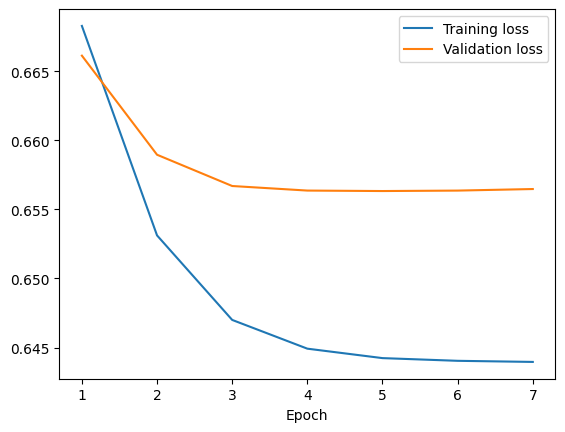

In [15]:
plot_losses(history)

## Random Forest as classical baseline 

Before finally evaluating the QNN, we also train a classical method to enable a comparison. A common choice for churn prediction is the Random Forest, which we will use as our baseline. The sklearn implementation with default settings (except the random seed) is trained below.

In [16]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(x_tr, y_tr)

RandomForestClassifier(random_state=4321)

## Final Evaluation

A basic intuition about the prediction quality achieved by our QNN can be provided by calculating accuracy values. Since the model yields expectation values between 0 and 1, we need to define a threshold (typically 0.5) for distinguishing between the two classes.

In [17]:
tr_preds = model.predict(x_tr) >= 0.5
val_preds = model.predict(x_val) >= 0.5
test_preds = model.predict(x_test) >= 0.5

tr_acc = accuracy_score(tr_preds, y_tr)
val_acc = accuracy_score(val_preds, y_val)
test_acc = accuracy_score(test_preds, y_test)
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

32/32 [==============================] - 7s 209ms/step
Train accuracy: 0.643625
Validation accuracy: 0.632
Test accuracy: 0.659


However, for a more complete and realistic evaluation, we need to:
<ul>
    <li>compare QNN performance against the Random Forest baseline</li>
    <li>compute a set of alternative measures that reflects the business logics in the task of churn prediction better than accuracy</li>
</ul>

In [18]:
print("PennyLane QNN:")
pd.DataFrame(classification_report(y_test, test_preds, output_dict=True))

PennyLane QNN:


,0,1,accuracy,macro avg,weighted avg
precision,0.801342,0.243137,0.659,0.522240,0.684119
recall,0.755696,0.295238,0.659,0.525467,0.659000
f1-score,0.777850,0.266667,0.659,0.522258,0.670502
support,790.000000,210.000000,0.659,1000.000000,1000.000000


In [19]:
print("sklearn Random Forest:")
pd.DataFrame(classification_report(y_test, rf.predict(x_test), output_dict=True))

sklearn Random Forest:


,0,1,accuracy,macro avg,weighted avg
precision,0.861017,0.756522,0.849,0.808769,0.839073
recall,0.964557,0.414286,0.849,0.689421,0.849000
f1-score,0.909851,0.535385,0.849,0.722618,0.831213
support,790.000000,210.000000,0.849,1000.000000,1000.000000


As a result, the comparison of the QNN and Random Forest shows that the latter is significantly better able to predict the minority class of churners. Of course, a real-world implementation would typically also try specific methods for dealing with class imbalances. In addition, the two models in this notebook did not go through a hyperparameter optimization procedure. Nevertheless, the comparison is taking place on common grounds, demonstrating that using variational QML models in an out-of-the-box manner does typically lead to worse results as opposed to established classical ML algorithms.